# Imports

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from matplotlib.pyplot import cm
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [2]:
def calc_daily_avg(df, dur="30min"):
    tmp = df[["count"]].copy()
    tmp["d"] = tmp.index.date
    tmp["t"] = map(lambda x: pd.datetime.combine(pd.datetime.today(), x), tmp.index.time)
    tmp = tmp.groupby(["d", "t"]).mean() \
                .unstack(level=0) \
                .resample(dur).mean() \
                .dropna(axis=1).T
    tmp.index = tmp.index.droplevel(0)
    return tmp

def plot_daily_avg(df, dur="30Min", clim=5, get_results=False, titles=None):
    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), 
                                   gridspec_kw={"height_ratios": [2, 5]})
    
    df.T.plot(ax=ax1, legend=False, c="k", alpha=0.3, lw=0.8)
    df.mean().T.plot(ax=ax1, c="r", label="Mean")
    ax1.fill_between(df.T.index, 
                     df.mean().T + 2 * df.std().values, 
                     df.mean().T - 2 * df.std().values, 
                     alpha=0.2, color="k", label="2 Std Dev")
    ax1.set_xlabel("Time (H:M)", fontsize=13)
    ax1.set_ylabel("Pedestrian Count", fontsize=13)
    handles, labels = ax1.get_legend_handles_labels()
    handles = handles[-3:]
    ax1.legend(handles, ["Daily Pedestrian Count", "Mean", "2 Std. Dev."])
    ax1.tick_params(axis="both", which="both", labelsize=12)
    
    im = ax2.imshow((df - df.mean()).values, clim=(-clim, clim),
                    cmap="viridis", aspect="auto")
    cbar = fig.colorbar(im, ax=ax2, orientation="horizontal", pad=0.1)
    cbar.ax.set_xlabel("Pedestrian Count")
    ax2.set_xticklabels(range(24))
    ax2.set_xticks(np.arange(-.5, 47.5, 2))
    ax2.grid(alpha=0.2)
    ax2.set_xlabel("Hour", fontsize=13)
    ax2.set_ylabel("Date", fontsize=13)
    ax2.set_yticks(range(len(df.index)))
    ax2.set_yticklabels(map(lambda x: x[0] + " " + x[1], 
                            zip(map(lambda x: x.strftime("%d-%m-%y"), df.index),
                            map(lambda x: x.strftime("%A")[:3], df.index))))
    ax2.tick_params(axis="x", which="both", labelsize=12)
    
    if titles != None:
        try:
            ax1.set_title(titles[0], fontsize=16)
            ax2.set_title(titles[1], fontsize=16)
        except:
            print "Passed titles are not list-like with len==2"
        
    fig.tight_layout()

def calc_reg_coefs(df_wd, df_we, precip):
    tmp = pd.concat([df_wd, df_we])
    data = []
    for idx in range(len(tmp)):
        day = tmp.iloc[[idx]].index[0]
        lm_df = pd.concat([tmp.iloc[[idx]].T, df_wd.mean(), df_we.mean()],
                          axis=1).rename(columns={day: "c", 0: "wd", 1: "we"})
        lm = smf.ols(formula="c ~ wd + we".format(lm_df.columns[0]), data=lm_df).fit()
        data.append([pd.datetime(day.year, day.month, day.day),
                     lm.params.wd, lm.params.we, lm.params.Intercept])
    data = pd.DataFrame(data, columns=["day", "wd_coef", "we_coef", "intercept"])
    data = data.merge(prcp, left_on="day", right_on="DATE")
    return data

def plot_reg_coefs(df_wd, df_we, precip, boro="BORO"):
    dayofweek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
               4:'Friday', 5:'Saturday', 6:'Sunday'}
    tmp = calc_reg_coefs(df_wd, df_we, precip)
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    xlim = [tmp.wd_coef.min() - .2, tmp.wd_coef.max() + .2]
    ylim = [tmp.we_coef.min() - .2, tmp.we_coef.max() + .2]
    
    for idx, ax in enumerate([ax1, ax2]):
        if ax == ax1:
            plot_data = tmp[tmp["day"].dt.weekday < 5]
            dd = "Weekdays"
        else:
            plot_data = tmp[tmp["day"].dt.weekday >= 5]
            dd = "Weekends"

        grps = plot_data.groupby(plot_data["day"].dt.weekday)
        color = iter(cm.viridis(np.linspace(0, 1, len(grps))))
        for nm, grp in grps:
            grp = grp.sort_values("PRCP", ascending=False)
            ax.scatter(grp.wd_coef, grp.we_coef, marker="o", 
                       label=dayofweek[nm], c=next(color), s=(100 - 100 * np.sqrt(grp.PRCP)))
        
        ax.set_ylabel("Weekend Coefficient", fontsize=14)
        ax.set_xlabel("Weekday Coefficient", fontsize=14)
        ax.set_title("{}".format(dd), fontsize=14)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        for i, txt in enumerate(plot_data.day.dt.date):
            if (abs(plot_data.wd_coef.values[i] - np.mean(plot_data.wd_coef.values)) > 1.5 * plot_data.wd_coef.values.std() or
                abs(plot_data.we_coef.values[i] - np.mean(plot_data.we_coef.values)) > 1.5 * plot_data.we_coef.values.std()):
                ax.text(plot_data.wd_coef.values[i],
                        plot_data.we_coef.values[i], txt)
        ax.legend()
    
    fig.suptitle("""Regression Coefficients in {} (TS(t) ~ Weekday Average(t) + Weekend Average(t))""".format(boro), 
                 fontsize=16, y=1.05)
    fig.tight_layout()

# Load Data

In [4]:
df = pd.read_feather("../data/results/hadive-data.feather").set_index("date")
print df.dtypes
df.head(2)

cam_id    int64
count     int64
dtype: object


,cam_id,count
date,,
2017-06-27 20:09:22,368,1
2017-06-27 20:09:23,360,1


In [5]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0,1,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1,0,Queens,11367


In [6]:
df = df.reset_index().merge(cams).set_index("date")[["cam_id", "count", "people", "boro"]]
df.head(2)

,cam_id,count,people,boro
date,,,,
2017-06-27 20:09:22,368,1,1,Manhattan
2017-06-27 20:10:39,368,1,1,Manhattan


In [7]:
prcp = pd.read_csv("../data/external/nyc_centralpark_2017precip.csv",
                   usecols=["DATE", "PRCP"], parse_dates=["DATE"])
prcp.sort_values("DATE", ascending=False).head(2)

,DATE,PRCP
248,2017-09-06,0.42
247,2017-09-05,0.00


# Anomaly Plots
## Manhattan
### Weekday

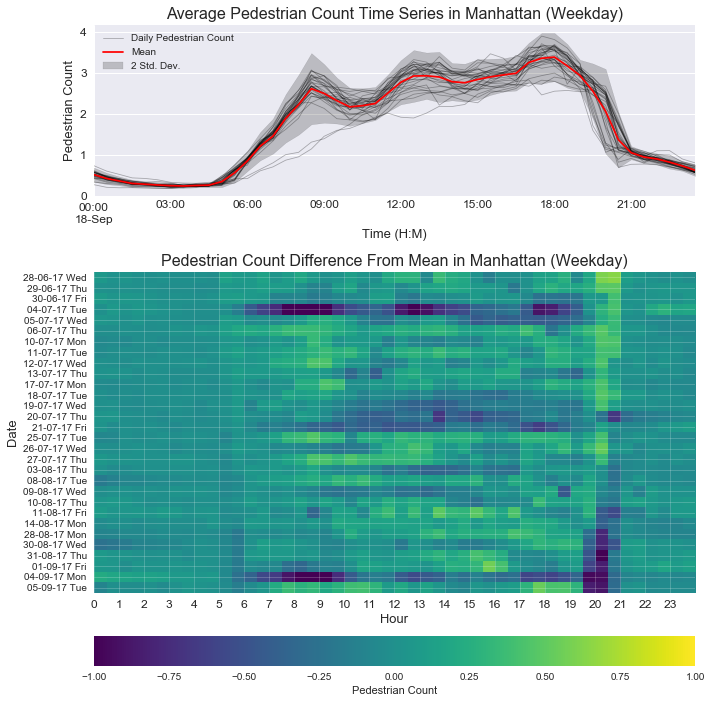

In [8]:
mn_wd = calc_daily_avg(df[(df.boro == "Manhattan") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5)])

plot_daily_avg(
    mn_wd[mn_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=1,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekday)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekday)"))

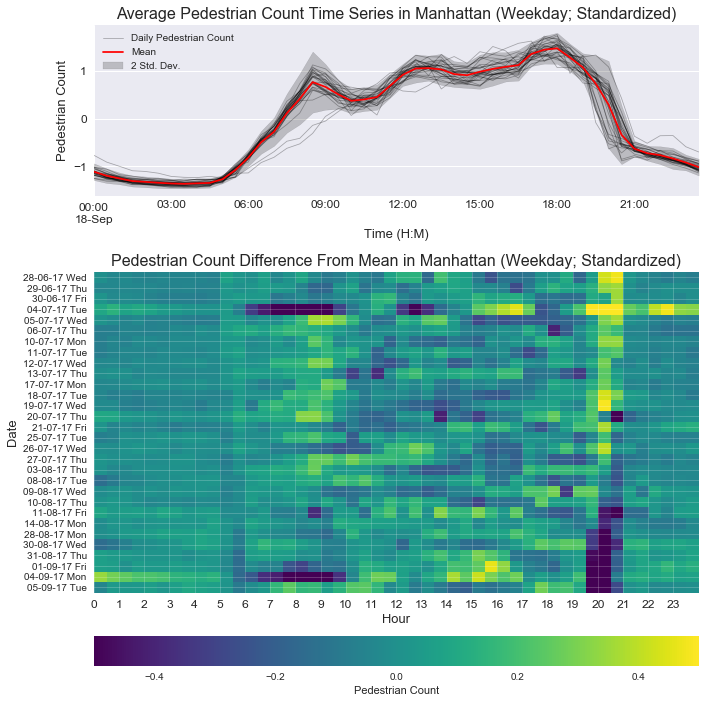

In [9]:
plot_daily_avg(
    mn_wd[mn_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=0.5,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekday; Standardized)"))

### Weekend

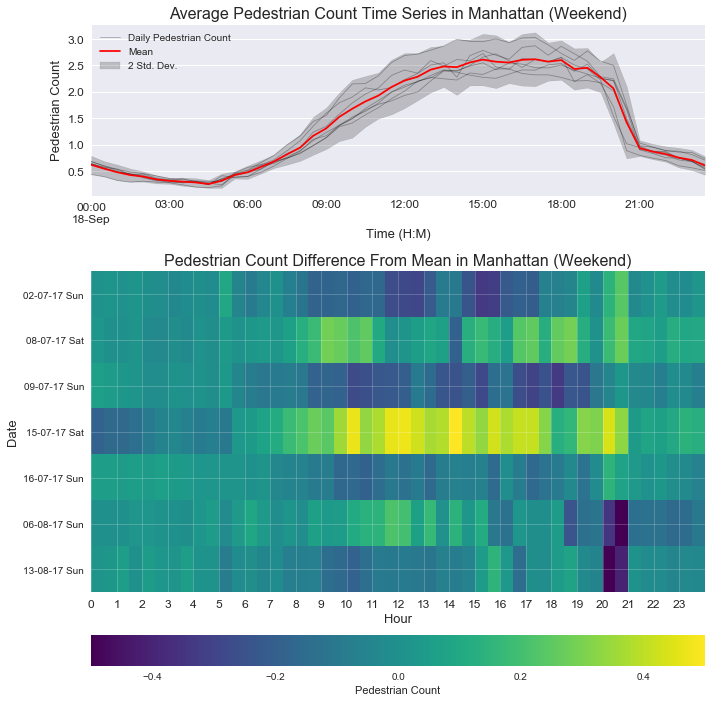

In [10]:
mn_we = calc_daily_avg(df[(df.boro == "Manhattan") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5)])

plot_daily_avg(
    mn_we[mn_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=0.5,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekend)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekend)"))

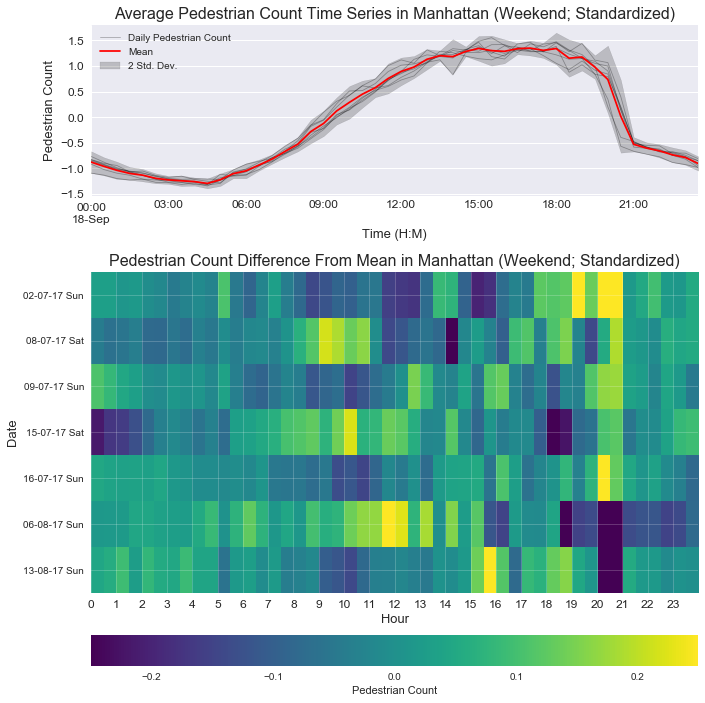

In [11]:
plot_daily_avg(
    mn_we[mn_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=0.25,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekend; Standardized)"))

/Users/JordanVani/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


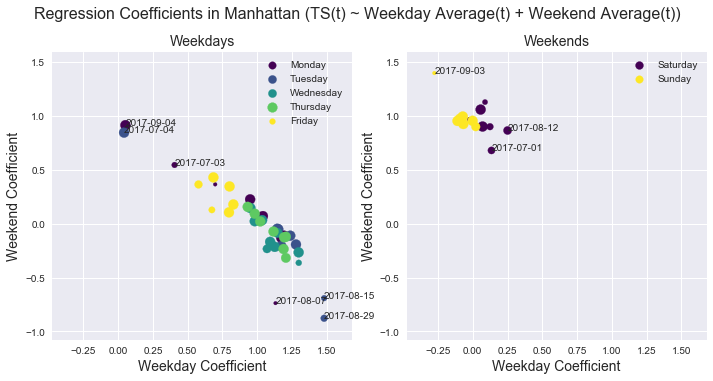

In [12]:
plot_reg_coefs(mn_wd, mn_we, prcp, "Manhattan")

## Brooklyn
### Weekday

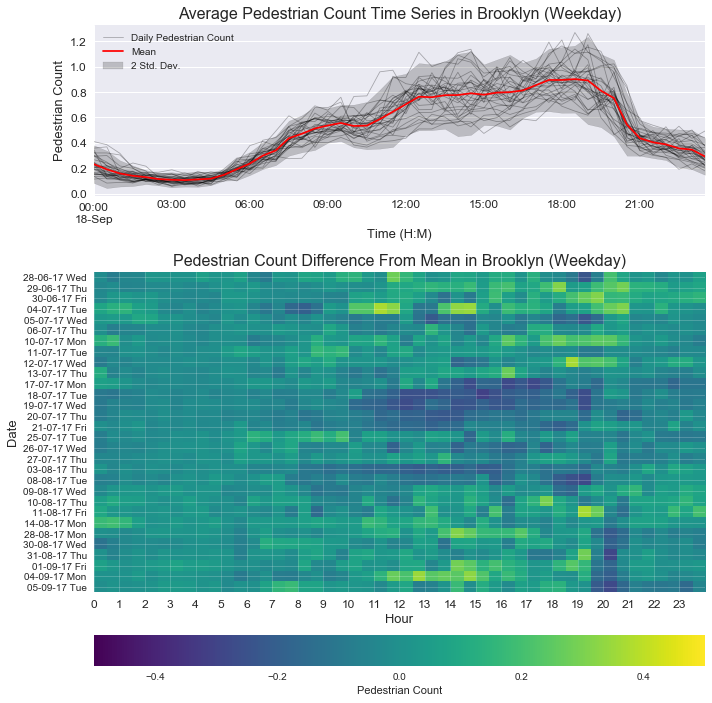

In [13]:
bk_wd = calc_daily_avg(df[(df.boro == "Brooklyn") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5)])

plot_daily_avg(
    bk_wd[bk_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=0.5,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekday)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekday)"))

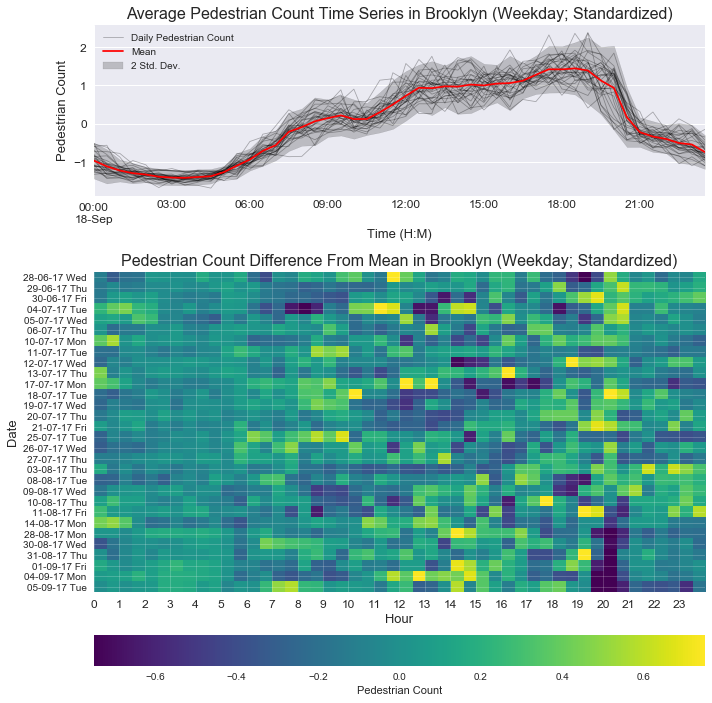

In [14]:
plot_daily_avg(
    bk_wd[bk_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=0.75,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekday; Standardized)"))

### Weekend

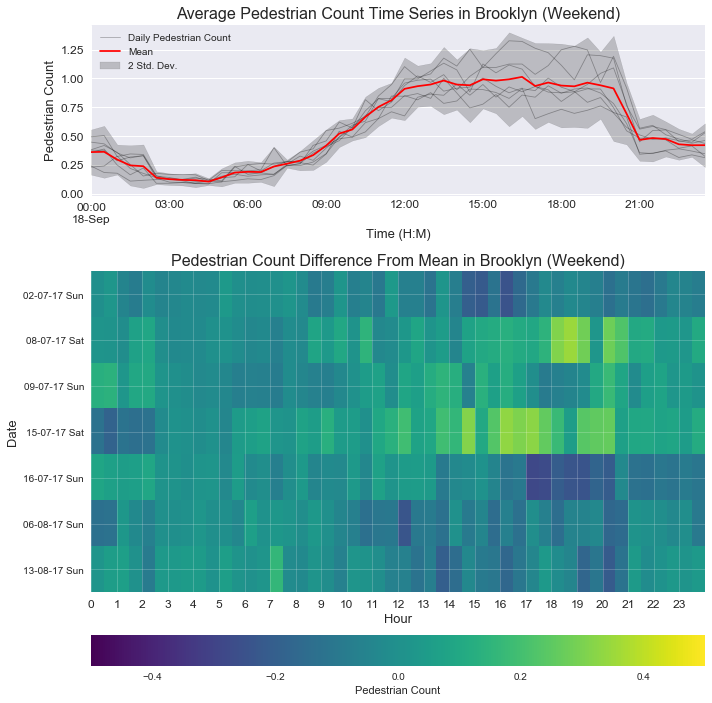

In [15]:
bk_we = calc_daily_avg(df[(df.boro == "Brooklyn") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5)])

plot_daily_avg(
    bk_we[bk_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=0.5,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekend)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekend)"))

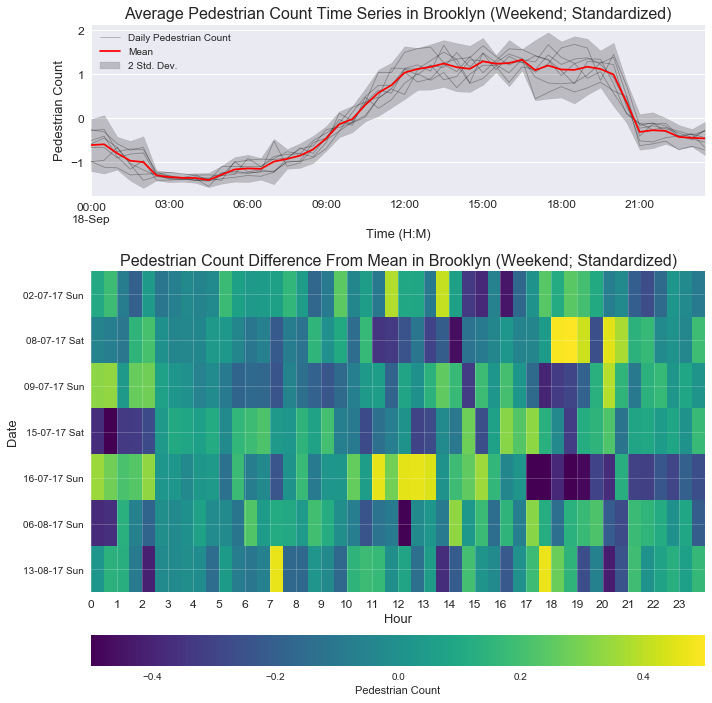

In [16]:
plot_daily_avg(
    bk_we[bk_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=0.5,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekend; Standardized)"))

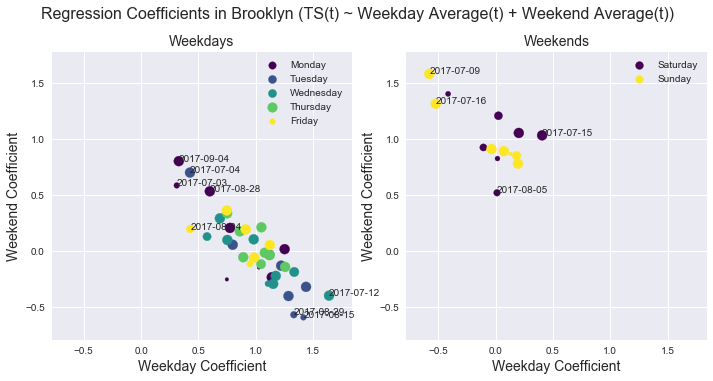

In [17]:
plot_reg_coefs(bk_wd, bk_we, prcp, "Brooklyn")

## Bronx
### Weekday

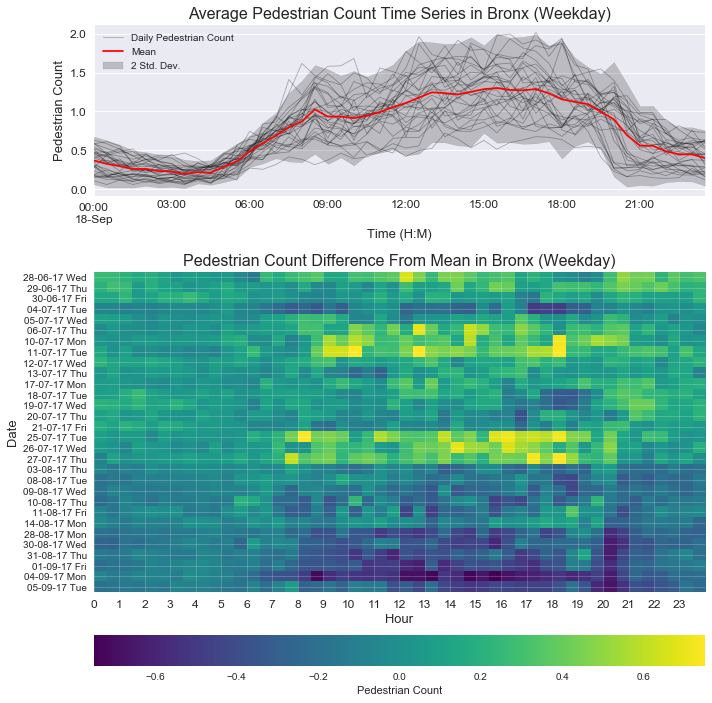

In [18]:
bx_wd = calc_daily_avg(df[(df.boro == "Bronx") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5)])

plot_daily_avg(
    bx_wd[bx_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=0.75,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekday)",
            "Pedestrian Count Difference From Mean in Bronx (Weekday)"))

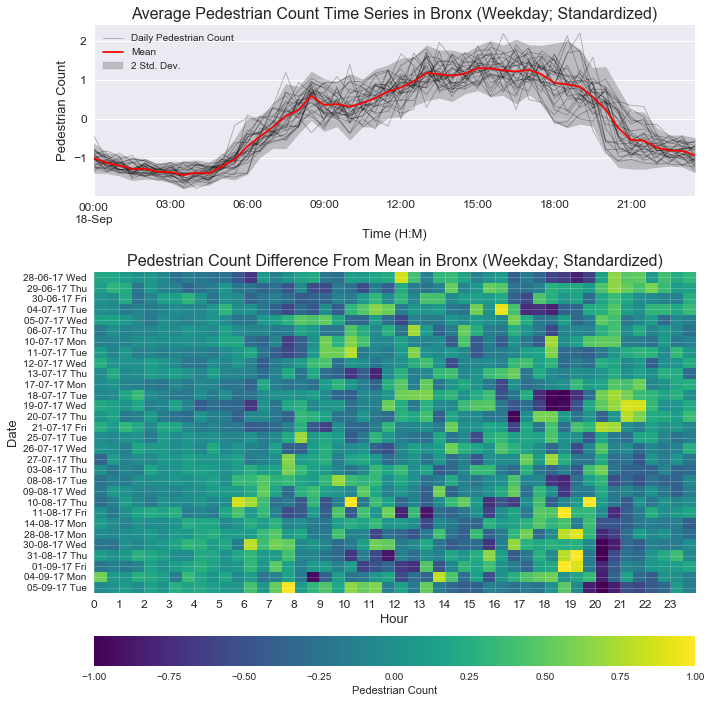

In [19]:
plot_daily_avg(
    bx_wd[bx_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=1,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Bronx (Weekday; Standardized)"))

### Weekend

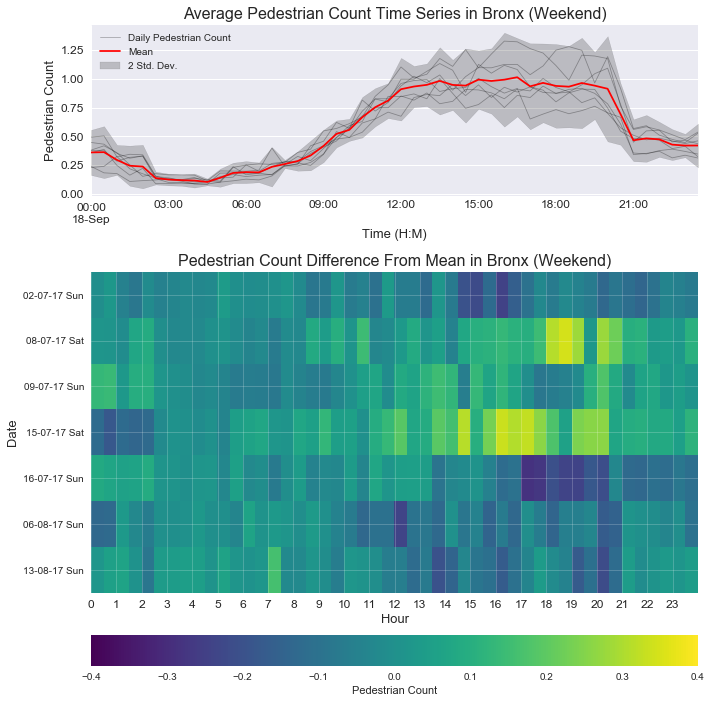

In [20]:
bx_we = calc_daily_avg(df[(df.boro == "Brooklyn") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5)])

plot_daily_avg(
    bx_we[bx_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=0.4,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekend)",
            "Pedestrian Count Difference From Mean in Bronx (Weekend)"))

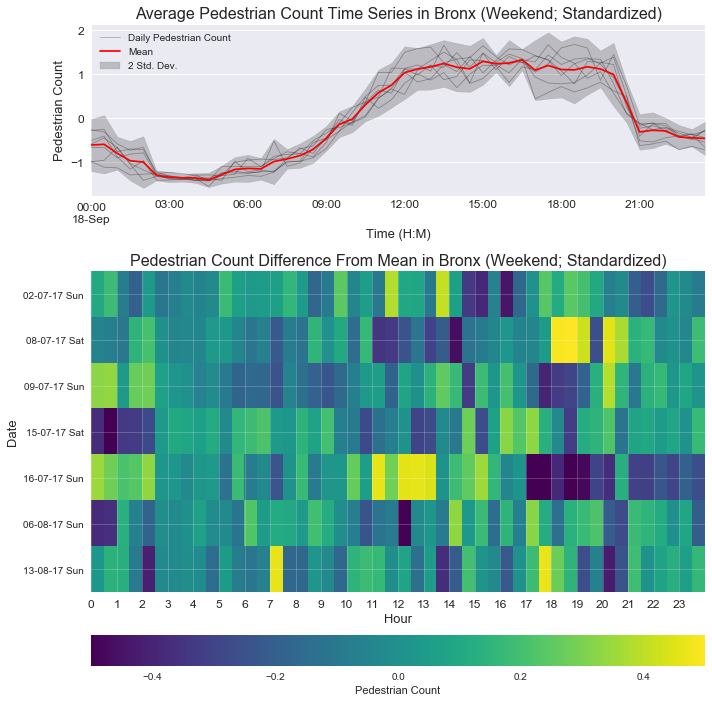

In [21]:
plot_daily_avg(
    bx_we[bx_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=0.5,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Bronx (Weekend; Standardized)"))

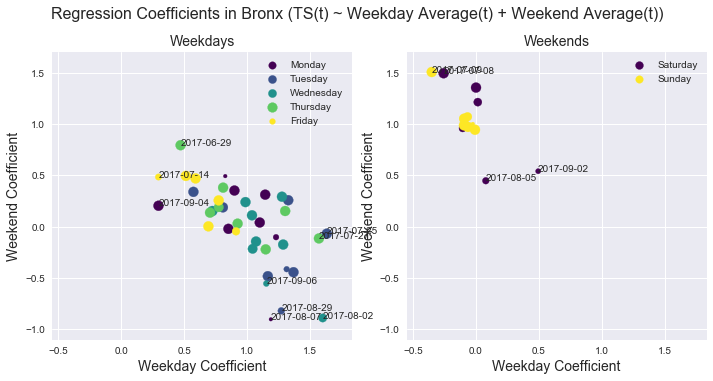

In [22]:
plot_reg_coefs(bx_wd, bx_we, prcp, "Bronx")

## Queens
### Weekday

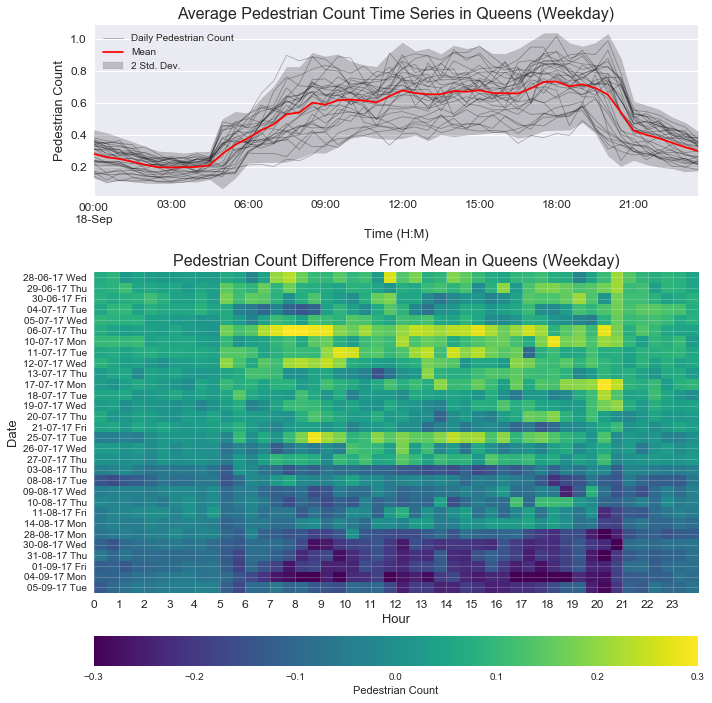

In [23]:
qn_wd = calc_daily_avg(df[(df.boro == "Queens") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5)])

plot_daily_avg(
    qn_wd[qn_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=0.3,
    titles=("Average Pedestrian Count Time Series in Queens (Weekday)",
            "Pedestrian Count Difference From Mean in Queens (Weekday)"))

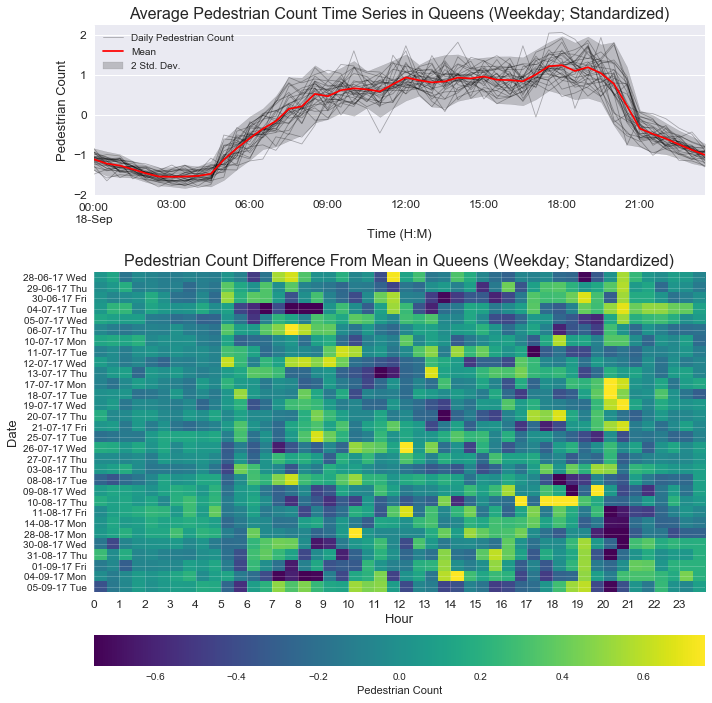

In [24]:
plot_daily_avg(
    qn_wd[qn_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=0.75,
    titles=("Average Pedestrian Count Time Series in Queens (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Queens (Weekday; Standardized)"))

### Weekend

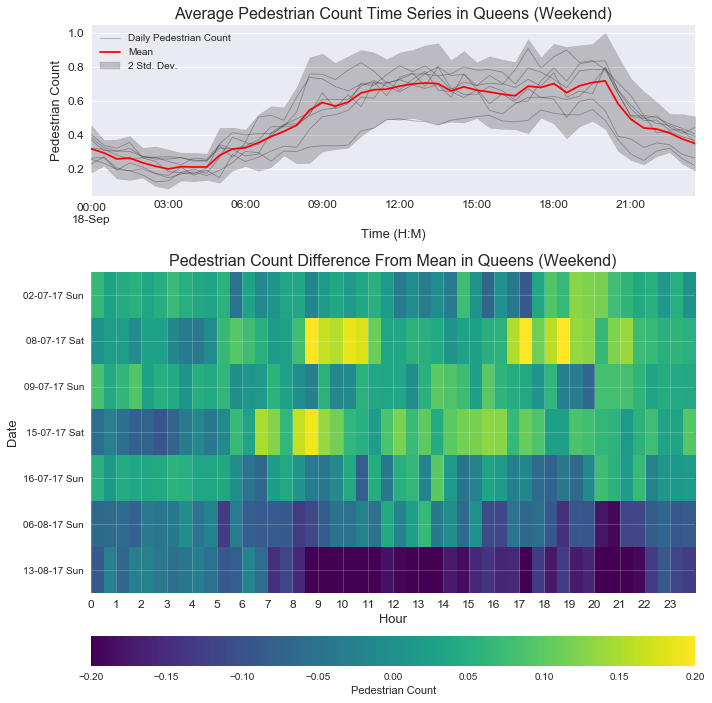

In [25]:
qn_we = calc_daily_avg(df[(df.boro == "Queens") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5)])

plot_daily_avg(
    qn_we[qn_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=0.2,
    titles=("Average Pedestrian Count Time Series in Queens (Weekend)",
            "Pedestrian Count Difference From Mean in Queens (Weekend)"))

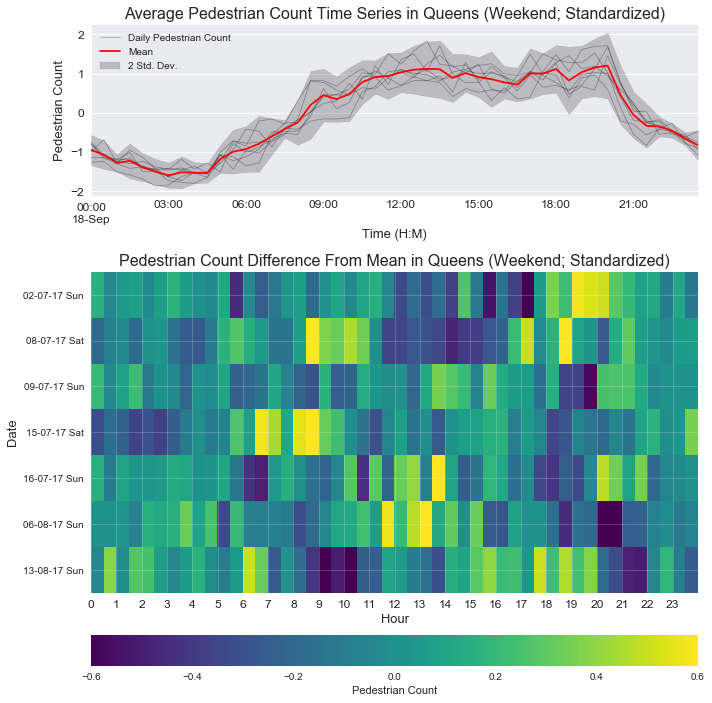

In [26]:
plot_daily_avg(
    qn_we[qn_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=0.6,
    titles=("Average Pedestrian Count Time Series in Queens (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Queens (Weekend; Standardized)"))

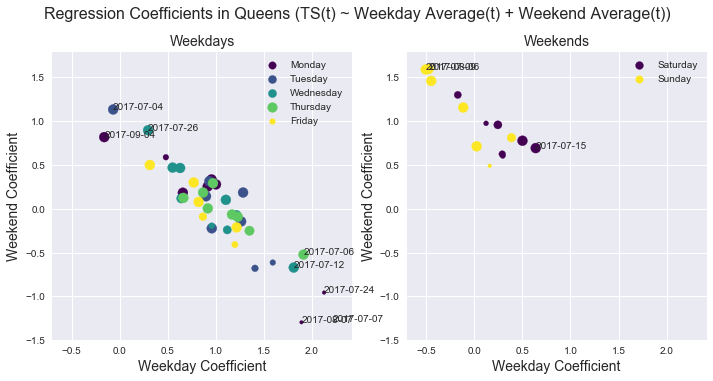

In [27]:
plot_reg_coefs(qn_wd, qn_we, prcp, "Queens")

## Staten Island
### Weekday

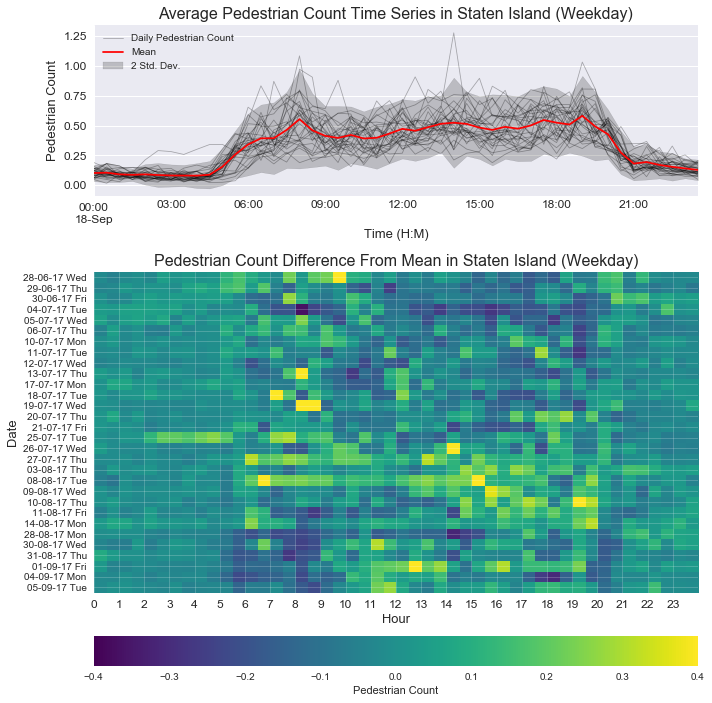

In [28]:
si_wd = calc_daily_avg(df[(df.boro == "Staten Island") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5)])

plot_daily_avg(
    si_wd[si_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=0.4,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekday)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekday)"))

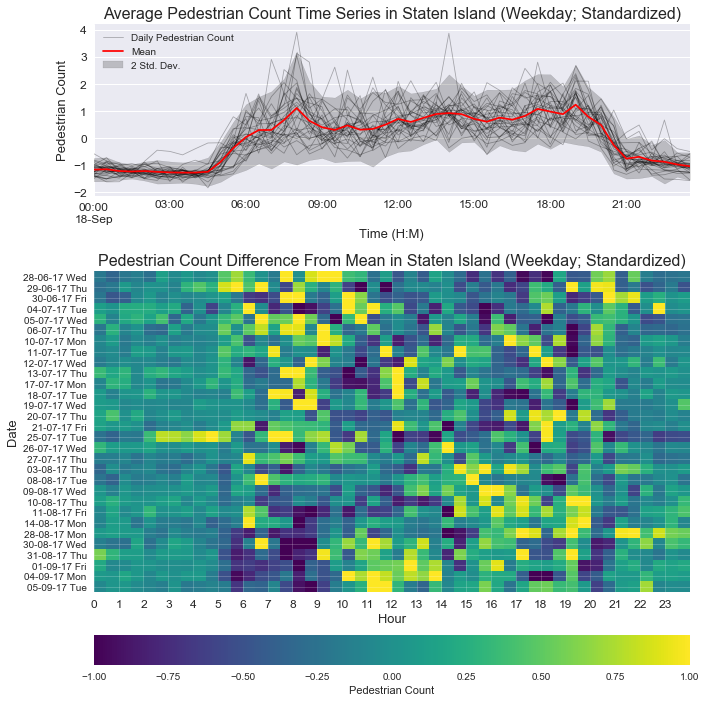

In [29]:
plot_daily_avg(
    si_wd[si_wd.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=1,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekday; Standardized)"))

### Weekend

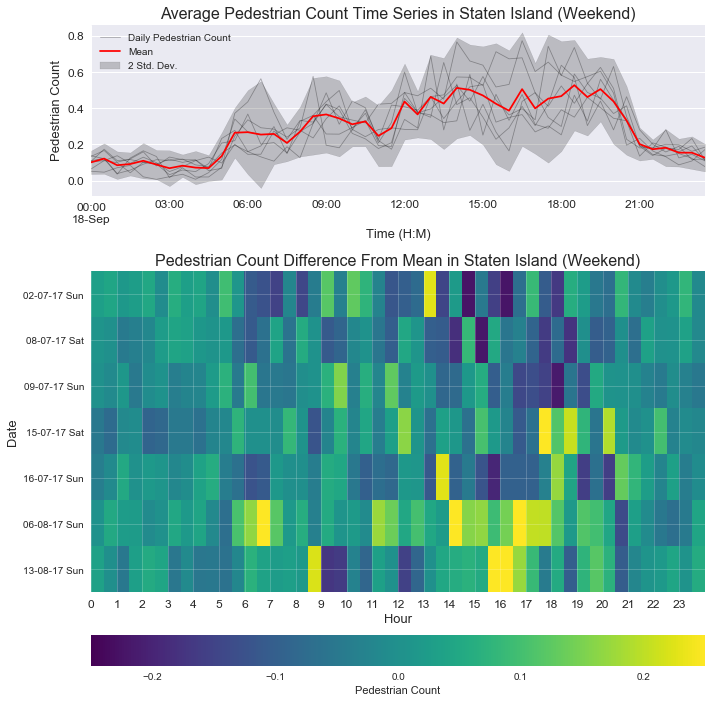

In [30]:
si_we = calc_daily_avg(df[(df.boro == "Staten Island") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5)])

plot_daily_avg(
    si_we[si_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)],
    clim=0.25,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekend)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekend)"))

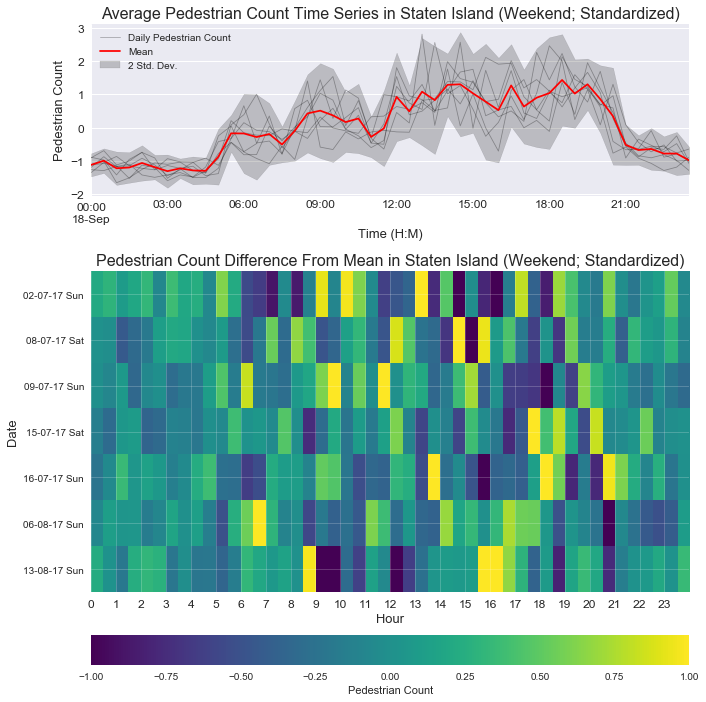

In [31]:
plot_daily_avg(
    si_we[si_we.index.isin(prcp[prcp["PRCP"] < 0.05]["DATE"].dt.date)].T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    clim=1,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekend; Standardized)"))

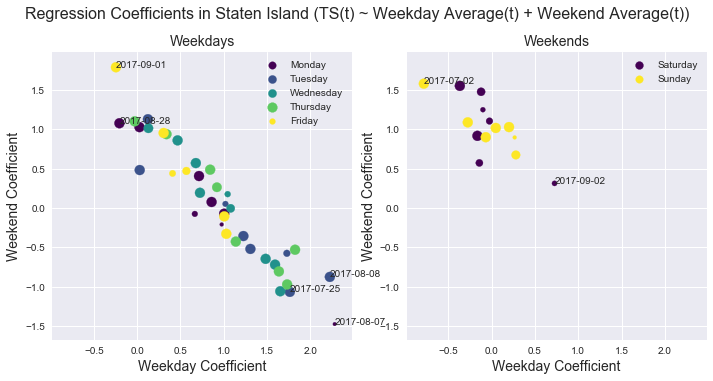

In [32]:
plot_reg_coefs(si_wd, si_we, prcp, "Staten Island")